In [2]:
# this notebook is going to test for randomly sampled locally equivalent gate, whether the basis gate set is sufficient to reconstruct the unitary with smushed gates
# we are going to test sqiswap, cnot, and syc as the 3 basis gates realized from gainconversion, CR, and fsim hamiltonians

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%matplotlib widget

import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import random_unitary
from slam.basisv2 import CircuitTemplateV2
from slam.utils.gates.custom_gates import ConversionGainSmushGate, ConversionGainGate
from slam.sampler import GateSample
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Operator
from slam.optimizer import TemplateOptimizer
from slam.cost_function import BasicCost, SquareCost

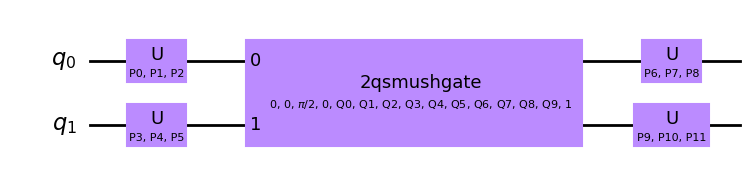

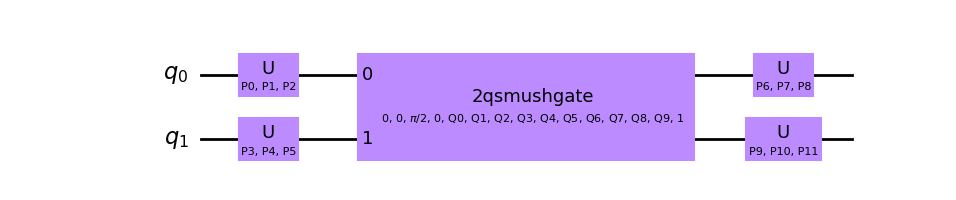

In [3]:
t= 1
timesteps = 5
duration_1q = t/timesteps
bounds_1q = 2*np.pi
vz_only=False

# fixing these to be iterated over
gc, gg = (1*np.pi/2, 0*np.pi/4)

varg_offset = 0 #set to 4 if want to use phase, and change 0s to vargs in pp2 constructor below
pp2 =lambda *vargs: ConversionGainSmushGate(0,0 , gc, gg, vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=vz_only, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
basis_str = "CG2Q"

# varg_offset = 2
# pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], gc, gg, vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q+P"

basis.build(1)
basis.spanning_range = range(1,2)

# for all smush gates make bounds
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -1*bounds_1q)

# # manually set the gc, gg bounds
# for el in basis.circuit.parameters:
#     s_el = str(el)
#     if s_el in ["Q0", "Q1", "Q22", "Q23", "Q44", "Q45"]:
#         basis.add_bound(s_el, .5, 0)
#         #basis.add_bound(s_el, 0.5*np.pi, 0) #XXX when using riswapgate should be 0.5, but when using ConversionGain should be np.pi/2 !!! BAD BAD BAD


# construct the locally variant target

qc = QuantumCircuit(2)
# qc.append(random_unitary(2), [0])
# qc.append(random_unitary(2), [1])
g = ConversionGainGate(0, 0, gc, gg, t_el=t)
qc.append(g, [0,1])
# qc.append(random_unitary(2), [0])
# qc.append(random_unitary(2), [1])
# qc.rx(-np.pi/2, 0)
# qc.rx(-np.pi/2, 1)
# qc.draw('mpl');
gate_data = Operator(qc).data

from slam.utils.gates.custom_gates import CanonicalGate
sampler = GateSample(CanonicalGate(np.pi / 4, np.pi / 8, np.pi/8))

from qiskit.circuit.library import CXGate, SwapGate, CPhaseGate
# gate_data = CXGate()
gate_data = SwapGate()
# gate_data = CPhaseGate(np.pi/2)
sampler = GateSample(UnitaryGate(gate_data))

s = [s for s in sampler][0]

objective1 = SquareCost()
optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=True, override_fail=True, success_threshold = 1e-7, training_restarts=5)
basis.circuit.draw(output='mpl')

INFO:root:Starting sample iter 0
INFO:root:Begin search: (0.5, 0.5, 0.5)
INFO:root:Starting opt on template size 1
100%|██████████| 5/5 [05:54<00:00, 70.88s/it]
INFO:root:Cycle (k =1), Best Loss=0.21715729159992414
INFO:root:Overall Best Loss=0.21715729159992414
INFO:root:Fail: (0.5, 0.5, 0.5), Found: (0.5, 0.25002534, 0.24997466)
/home/evm9/slam_decomposition/slam/utils/visualize.py:84: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


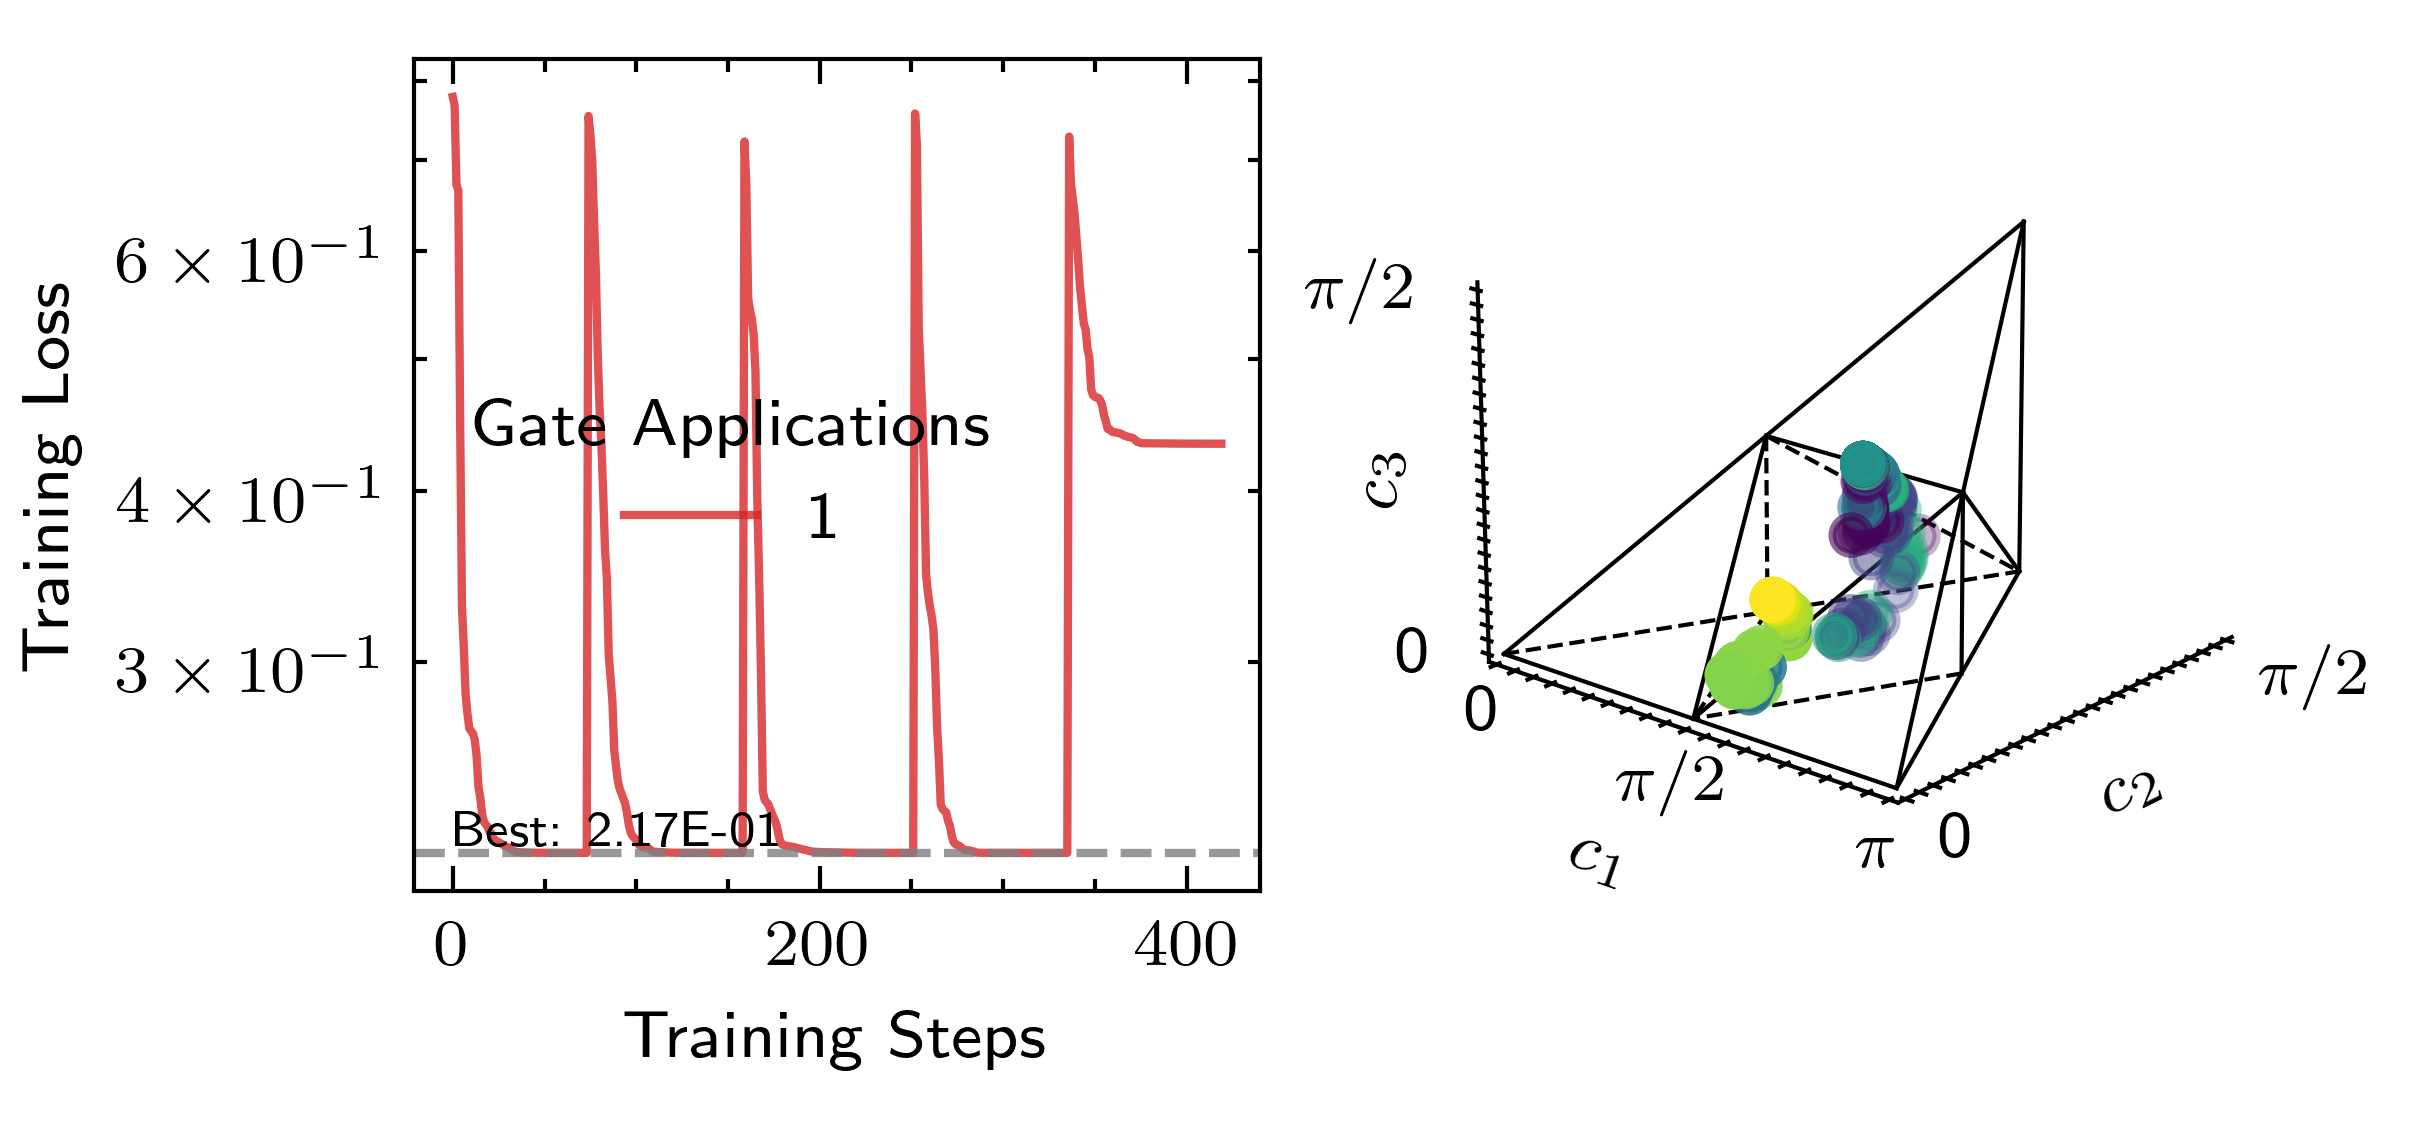

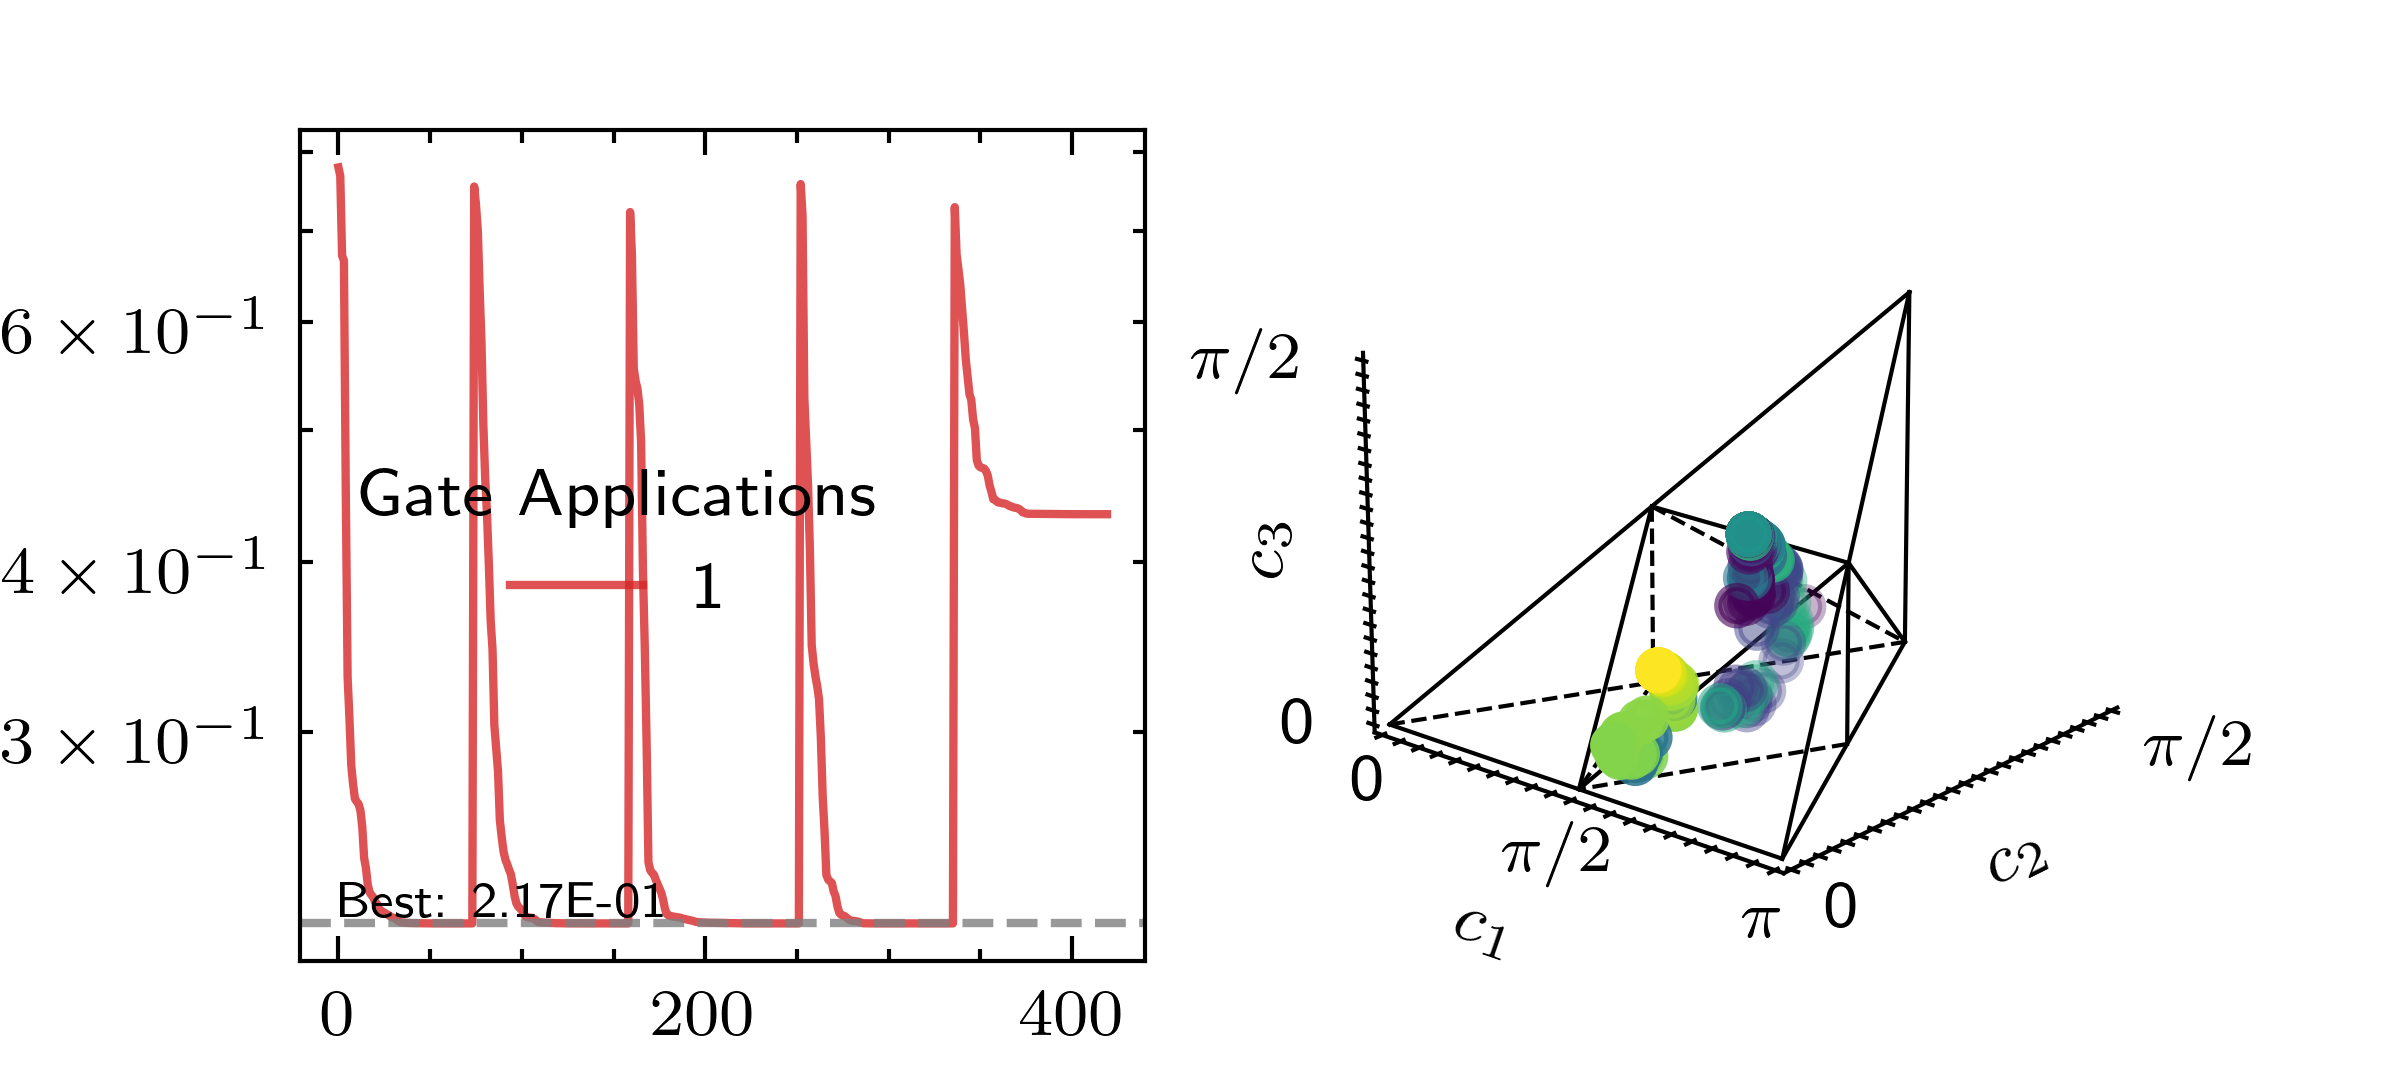

In [4]:
_ret3 = optimizer3.approximate_from_distribution(sampler)
from slam.utils.visualize import optimizer_training_plot
optimizer_training_plot(_ret3[0], _ret3[1])

In [22]:
# _ret3 = optimizer3.approximate_target_U(s)
#ret3[2] gets the target_data list, [0] returns the first element over the sampler distribution (we only put one in)
transp1 = basis.reconstruct(_ret3[2][0])
transp1.draw()

Cost: 0.8


┌──────────────────────────────────────────────────────────┐»
q_0: ┤ U(-8.68447858575178,-0.425997814647864,1.12322226588598) ├»
     ├─────────────────────────────────────────────────────────┬┘»
q_1: ┤ U(-7.57782363819577,-5.72403927306884,4.46355732206795) ├─»
     └─────────────────────────────────────────────────────────┘ »
«     ┌───────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                  ├»
«     │  2qsmushgate(0,0,π/2,0,0.0,0.0,4.1396568148832,0.0,0.0,6.20954654382556,2π,0.227004893285954,0.8) │»
«q_1: ┤1                                                                                                  ├»
«     └───────────────────────────────────────────────────────────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────────────────┐
«q_0: ┤ U(-2.06508674601652,-0.0483287950740079,12.1805356849437) ├
«     └┬─────────────────────────────────────────────────────────┬┘
«q_1: ─┤ U(2.08561222363122,-2.78918183307475,-10.2121694108132) ├─
«      └─────────────────────────────────────────────────────────┘

In [28]:
#replace the smush gate with smaller gates
from slam.utils.gates.custom_gates import ConversionGainSmushGate
transp2 = QuantumCircuit(2)
#iterate gates in transp1
for gate in transp1:
    # if the gate is a smush gate
    if isinstance(gate[0], ConversionGainSmushGate):
        # get the parameters of the smush gate
        params = gate[0].params
        # get the qubits of the smush gate
        qubits = gate[1]
        # replace the smush gate with the smaller set of gates
        for i in range(timesteps):
            d_gate = ConversionGainSmushGate(params[0],params[1], params[2], params[3], [params[4+i]], [params[4+timesteps+i]], t_el=Parameter(f't{i}'))
            transp2.append(d_gate, qubits)
    else:
        # if the gate is not a smush gate, just append it
        transp2.append(gate[0], gate[1])
transp2.draw()

┌──────────────────────────────────────────────────────────┐»
q_0: ┤ U(-8.68447858575178,-0.425997814647864,1.12322226588598) ├»
     ├─────────────────────────────────────────────────────────┬┘»
q_1: ┤ U(-7.57782363819577,-5.72403927306884,4.46355732206795) ├─»
     └─────────────────────────────────────────────────────────┘ »
«     ┌────────────────────────────────────┐»
«q_0: ┤0                                   ├»
«     │  2qsmushgate(0,0,π/2,0,0.0,0.0,t0) │»
«q_1: ┤1                                   ├»
«     └────────────────────────────────────┘»
«     ┌─────────────────────────────────────────────────┐»
«q_0: ┤0                                                ├»
«     │  2qsmushgate(0,0,π/2,0,0.0,6.20954654382556,t1) │»
«q_1: ┤1                                                ├»
«     └─────────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────┐»
«q_0: ┤0                                              ├»
«     │  2qsmushgate(0,0,π/2,0,4.1396568148832,2π,t2) │»
«q_1: ┤1                                              ├»
«     └───────────────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────┐»
«q_0: ┤0                                                 ├»
«     │  2qsmushgate(0,0,π/2,0,0.0,0.227004893285954,t3) │»
«q_1: ┤1                                                 ├»
«     └──────────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────────────────┐
«q_0: ┤ U(-2.06508674601652,-0.0483287950740079,12.1805356849437) ├
«     └┬─────────────────────────────────────────────────────────┬┘
«q_1: ─┤ U(2.08561222363122,-2.78918183307475,-10.2121694108132) ├─
«      └─────────────────────────────────────────────────────────┘

In [26]:
from weylchamber import c1c2c3
endpoints = [2,3,4,5,6,7,9] #XXX hardcoded
endpoints = [2,3,4,5,6,8]
coordinate_list = []


for end in endpoints:
    qc = QuantumCircuit(2)
    for gate in transp2[0:end]:
        qc.append(gate[0], gate[1])
    
    qc2 = qc.copy()
    # if we stop on a 2Q gate
    if end in endpoints[1:-1]: #XXX hardcoded

        # for all prior 2Q gates, set time parameter to full length
        for i in [el for el in endpoints[1:-1] if el < end]:
            qc2 = qc2.bind_parameters({qc2[i-1][0].params[-1] : duration_1q} )

        # for current 2Q gate, iterate over time and append coordinate
        for t in np.linspace(0,duration_1q, 25):
            qc3 = qc2.bind_parameters({qc2[end-1][0].params[-1]: t})
            #eliminating x-axis symmetry
            c = list(c1c2c3(Operator(qc3).data))
            if c[0] > 0.5:
                c[0] = -1*c[0] + 1
            coordinate_list.append(c)
    # if we stop on a 1Q gate
    else:
        # for all prior 2Q gates, set time parameter to full length
        for i in [el for el in endpoints[1:-1] if el < end]:
            qc2 = qc2.bind_parameters({qc2[i-1][0].params[-1] : duration_1q} )
        #eliminating x-axis symmetry
        c = list(c1c2c3(Operator(qc2).data))
        if c[0] > 0.5:
            c[0] = -1*c[0] + 1
        #append coordinate for duration of 1Q gate
        for t in np.linspace(0,duration_1q, 25):
            coordinate_list.append(c)

# qc2.draw(output='mpl');

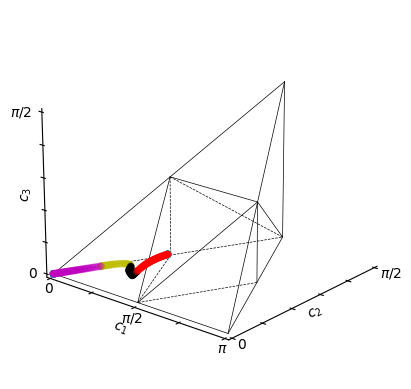

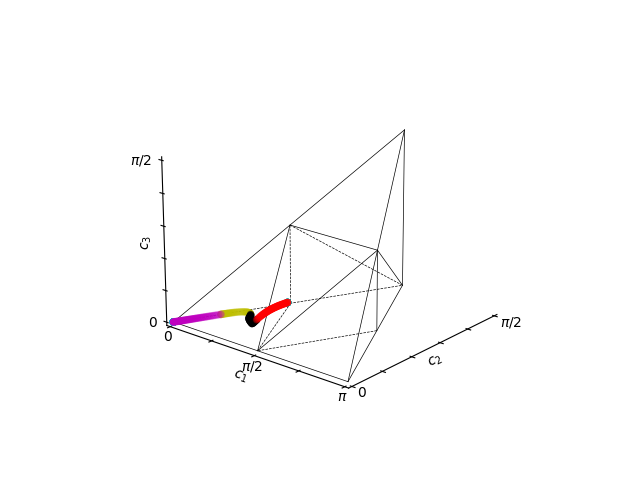

In [27]:
from slam.utils.visualize import coordinate_2dlist_weyl
coordinate_2dlist_weyl(*[coordinate_list[i:i+25] for i in [0, 25, 50, 75, 100, 125]])#, c=np.linspace(0, 1+2*duration_1q, len(coordinate_list)));

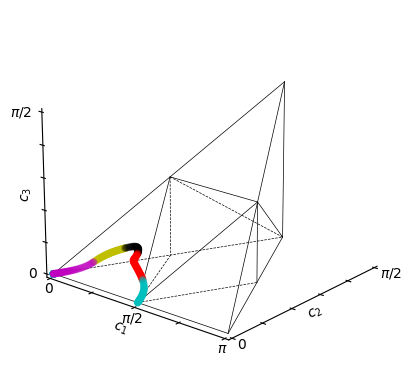

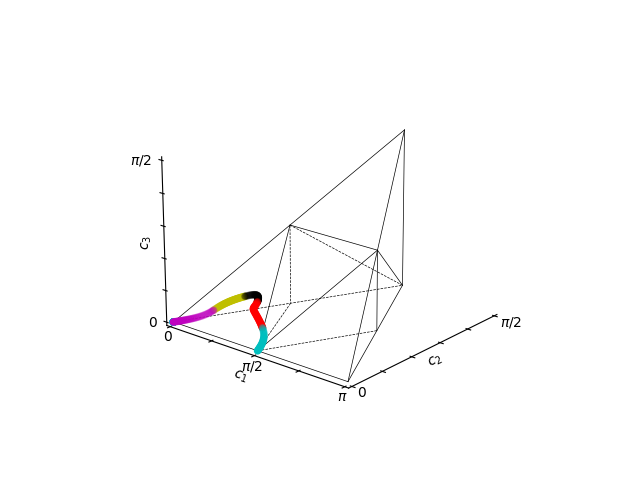

In [18]:
from slam.utils.visualize import coordinate_2dlist_weyl
coordinate_2dlist_weyl(coordinate_list)#, c=np.linspace(0, 1+2*duration_1q, len(coordinate_list)));

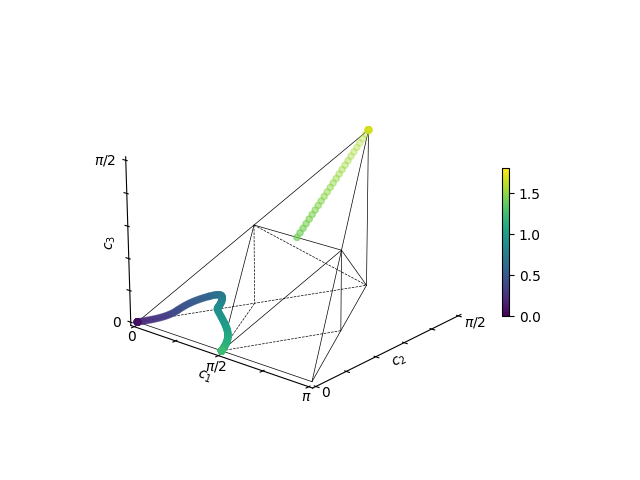

In [10]:
#for sqiswap making SWAP, we append a normal sqiswap gate, borrowed from the basic decomposition after we reach this middle point
#XXX hardcoded from decomp_trajectory.ipynb
coordinate_list.extend([[0.49997065, 0.24999824, 0.24997135],
 [0.49997065, 0.26041491, 0.26038801],
 [0.49997065, 0.27083157, 0.27080468],
 [0.49997065, 0.28124824, 0.28122135],
 [0.49997065, 0.29166491, 0.29163801],
 [0.49997065, 0.30208157, 0.30205468],
 [0.49997065, 0.31249824, 0.31247135],
 [0.49997065, 0.32291491, 0.32288801],
 [0.49997065, 0.33333157, 0.33330468],
 [0.49997065, 0.34374824, 0.34372135],
 [0.49997065, 0.35416491, 0.35413801],
 [0.49997065, 0.36458157, 0.36455468],
 [0.49997065, 0.37499824, 0.37497135],
 [0.49997065, 0.38541491, 0.38538801],
 [0.49997065, 0.39583157, 0.39580468],
 [0.49997065, 0.40624824, 0.40622135],
 [0.49997065, 0.41666491, 0.41663801],
 [0.49997065, 0.42708157, 0.42705468],
 [0.49997065, 0.43749824, 0.43747135],
 [0.49997065, 0.44791491, 0.44788801],
 [0.49997065, 0.45833157, 0.45830468],
 [0.49997065, 0.46874824, 0.46872135],
 [0.49997065, 0.47916491, 0.47913801],
 [0.49997065, 0.48958157, 0.48955468],
 [0.49999821, 0.49997201, 0.49996939]])

for t in np.linspace(0,duration_1q, 25):
            coordinate_list.append((.5, .5, .5))

coordinate_2dlist_weyl(coordinate_list, c=np.linspace(0, 1.8, len(coordinate_list)));

In [11]:
len(coordinate_list)

225